<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/TF_7_%EC%BC%80%EB%9D%BC%EC%8A%A4_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%B2%98%EB%A6%AC_%EB%B0%8F_%EC%9E%84%EB%B2%A0%EB%94%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 텍스트 처리 및 임베딩

- 코드 참조: 케라스 창시자에게 배우는 딥러닝



## 용어 설명

- `토큰(token)`
  - 텍스트를 나누는 단위

  - 토큰화(tokenization): 토큰으로 나누는 작업

- `n-gram`
  - 문장에서 추출한 N개(또는 그 이하)의 연속된 단어 그룹

  - 같은 개념이 '문자'에도 적용가능

  <img src="https://www.sqlservercentral.com/wp-content/uploads/legacy/0bf6a2bd621db172dba029ce3c712280a3f6aab3/29444.jpg">

  <sub>출처: https://www.sqlservercentral.com/articles/nasty-fast-n-grams-part-1-character-level-unigrams</sub>

## 문자 수준 원-핫 인코딩

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import numpy as np

In [ ]:
samples = ['The cat sat on the mat.',
           'The dog ate my homeworks.']

token_index = {}

In [ ]:
for sample in samples:
  for word in sample.split():
    if word not in token_index:
      token_index[word] = len(token_index) + 1

max_len = 10
results = np.zeros(shape=(len(samples), max_len,
                          max(token_index.values()) + 1))

In [ ]:
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_len]:
    index = token_index.get(word)
    results[i, j, index] = 1.

results

## 케라스를 사용한 단어 수준 원-핫 인코딩

- `fit_on_texts()`

- `texts_to_sequences()`

- `texts_to_matrix()`

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization

In [ ]:
samples = ['The cat sat on the mat.',
           'The dog ate my homeworks.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

ohe_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print(len(word_index))

{'ate': 7,
 'cat': 2,
 'dog': 6,
 'homeworks': 9,
 'mat': 5,
 'my': 8,
 'on': 4,
 'sat': 3,
 'the': 1}

In [ ]:
VOCAB_SIZE = 1000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

binary_vectorize_layer.adapt(samples)

binary_vectorize_layer('The')

In [ ]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [ ]:
print(ohe_results.shape)
print(ohe_results)

(2, 1000)
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


### 토큰화 예제

- `OOV` : Out of Vocabulary
  - 새로운 문장에서 기존에 토큰화한 문장에 존재하지 않으면 OOV로 대체됨

In [ ]:
samples = ["I'm the smartest student.",
           "I'm the best student."]

tokenizer = Tokenizer(num_words=10, oov_token='<OOV>')
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

binary_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, "i'm": 2, 'the': 3, 'student': 4, 'smartest': 5, 'best': 6}


In [ ]:
binary_results

array([[0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 1., 0., 0., 0.]])

테스트

In [ ]:
test = ["I'm the fastest student."]
test_seq = tokenizer.texts_to_sequences(test)

In [ ]:
print("word_index:", tokenizer.word_index)
print("test text:", test)
print("test seq:", test_seq)

word_index: {'<OOV>': 1, "i'm": 2, 'the': 3, 'student': 4, 'smartest': 5, 'best': 6}
test text: ["I'm the fastest student."]
test seq: [[2, 3, 1, 4]]


## 원-핫 단어 벡터와 단어 임베딩

- `원-핫 단어 벡터`
  - 데이터가 희소(sparse)

  - 고차원

- `단어 임베딩`
  - 밀집(dense)

  - 저차원

  <img src="https://freecontent.manning.com/wp-content/uploads/Chollet_DLfT_02.png" width="400">

  <sub>출처: https://freecontent.manning.com/deep-learning-for-text/</sub>

## 단어 임베딩
- 단어간 벡터사이의 **거리가 가까운**, 즉 비슷한 단어들끼리 임베딩

- 거리 외에 임베딩 공간의 특정 방향도 의미를 가질 수 있음


<img src="https://miro.medium.com/max/3010/1*OEmWDt4eztOcm5pr2QbxfA.png">

<sub>출처: https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8</sub>


## Embedding Layer

- 특정 단어를 나타내는 정수 인덱스를 밀집 벡터(dense vector)로 매핑하는 딕셔너리 레이어

- 입력: `(samples, sequence_length)`

- 출력: `(samples, sequnece_length, dim)`

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(1000, 64)
embedding_layer

## 예제 : IMDB 데이터

- 인터넷 영화 데이터베이스(Internet Movie Database)

- 양극단의 리뷰 5만개로 이루어진 데이터셋
  - 훈련데이터: 25,000개
  - 테스트데이터 : 25,000개

  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQlk-f2SHB6-Vs3RWwIugMctsyEn2QVZWC5KQ&usqp=CAU">

- https://www.imdb.com/interfaces/

### module import

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input

### 데이터 로드

In [ ]:
num_words = 1000
max_len = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


### 데이터 확인
- 긍정: 1
- 부정: 0

In [ ]:
print(x_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1


In [ ]:
for i in range(10):
  if y_train[i] == 0:
    label = "부정"
  else:
    label = "긍정"

  print("Review Seq: {}\nLabel: {}".format(x_train[i], label))

Review Seq: [1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
Label: 긍정
Review Seq: [1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 715, 8, 118, 2, 14, 394, 20, 13, 119, 9

### (참고) IMDB 데이터셋에서 가장 많이 사용된 단어

In [ ]:
word_index = {}

for key, val in imdb.get_word_index().items():
  word_index[val] = key

for i in range(1, 6):
  print(word_index[i])


1654784/1641221 [==============================] - 0s 0us/step
the
and
a
of
to


### 데이터 전처리
- 모든 데이터를 같은 길이로 맞추기

  - `pad_sequence()`
    - 데이터가 maxlen보다 길면 데이터를 자름

    - 데이터가 길면 `padding` 설정
      - `pre`: 데이터 앞에 0으로 채움
      -  `post`: 데이터 뒤에 0으로 채움


- 모든 데이터(문장 하나하나)가 같은 길이로 맞춰저야 `Embedding` 레이어를 사용할 수 있음

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
pad_x_train = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

In [ ]:
print(len(x_train[0]))
print(len(pad_x_train[0]))

218
20


In [ ]:
print(x_train[0])
print(pad_x_train[0])

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
[ 65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32]


### 모델 구성

In [ ]:
with tpu_strategy.scope():
  model = Sequential()

  model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_len))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 32)            32000     
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 641       
                                                                 
Total params: 32,641
Trainable params: 32,641
Non-trainable params: 0
_________________________________________________________________


### 모델 컴파일 및 학습

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(pad_x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6335 - acc: 0.6558 - val_loss: 0.5627 - val_acc: 0.7084
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.5117 - acc: 0.7471 - val_loss: 0.5319 - val_acc: 0.7280
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.4769 - acc: 0.7695 - val_loss: 0.5255 - val_acc: 0.7364
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.4551 - acc: 0.7835 - val_loss: 0.5313 - val_acc: 0.7302
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4333 - acc: 0.7990 - val_loss: 0.5398 - val_acc: 0.7276
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4120 - acc: 0.8130 - val_loss: 0.5471 - val_acc: 0.7248
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3908 - acc: 0.8267 - val_loss: 0.5600 - val_acc: 0.7210
Epoch 8/10
625/625 [==============================] - 9s 14ms/step -

### 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

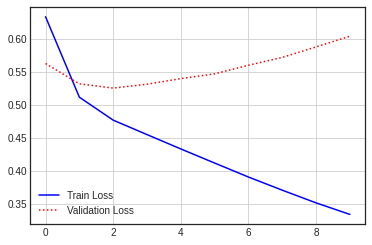

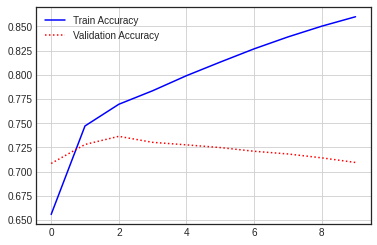

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

### 모델 평가

In [ ]:
model.evaluate(pad_x_test, y_test)

782/782 [==============================] - 13s 16ms/step - loss: 0.6032 - acc: 0.7091


[0.6031615734100342, 0.7090799808502197]

### 단어의 수를 늘린 후 재학습

In [ ]:
num_words = 1000
max_len = 500

pad_x_train_2 = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test_2 = pad_sequences(x_test, maxlen=max_len, padding='pre')

데이터 확인

In [ ]:
print(x_train[0])
print(pad_x_train_2[0])

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [ ]:
with tpu_strategy.scope():
  model2 = Sequential()

  model2.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_len))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))

  model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           32000     
                                                                 
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16001     
                                                                 
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history2 = model2.fit(pad_x_train_2, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 0.5142 - acc: 0.7349 - val_loss: 0.3617 - val_acc: 0.8462
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3133 - acc: 0.8681 - val_loss: 0.3319 - val_acc: 0.8614
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.2685 - acc: 0.8891 - val_loss: 0.3726 - val_acc: 0.8448
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.2305 - acc: 0.9090 - val_loss: 0.3443 - val_acc: 0.8586
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1906 - acc: 0.9295 - val_loss: 0.3617 - val_acc: 0.8508
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1523 - acc: 0.9465 - val_loss: 0.3947 - val_acc: 0.8418
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1186 - acc: 0.9635 - val_loss: 0.4236 - val_acc: 0.8408
Epoch 8/10
625/625 [==============================] - 9s 14ms/step -

In [ ]:
hist_dict2 = history2.history
hist_dict2.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

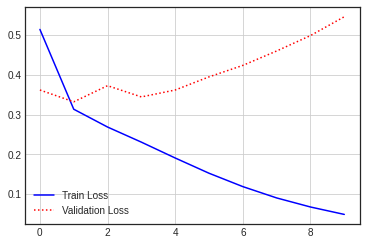

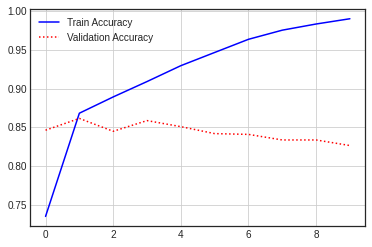

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model2.evaluate(pad_x_test_2, y_test)

782/782 [==============================] - 13s 16ms/step - loss: 0.5205 - acc: 0.8322


[0.5205152630805969, 0.8322399854660034]

위의 결과도 나쁘지 않으나 과적합이 되는 이유
- 단어간 관계나 문장 구조 등 의미적 연결을 고려하지 않음

- 시퀀스 전체를 고려한 특성을 학습하는 것은 `Embedding`층 위에 `RNN`층이나 `1D 합성곱`을 추가하는 것이 좋음


## 단어 임베딩의 종류
- LSA

- Word2Vec

- GloVe

- FastText

- etc..

<!-- ## 사전 훈련된 모델
https://github.com/Hironsan/awesome-embedding-models#pre-trained-word-vectors -->

## Word2Vec

- 2013년, Mikolov 와 동료들이 제안한 모형

- 분류 등과 같이 별도의 레이블이 없이 텍스트 자체만 있어도 학습이 가능

- Word2Vec의 방식  
  주변 단어의 관계를 이용

  - CBOW(continuous bag-of-words)
    - 주변단어의 임베딩을 더해서 대상단어를 예측

  - Skip-Gram
    - 대상 단어의 임베딩으로 주변단어를 예측

    - 일반적으로 CBOW보다 성능이 좋은 편

    - 한번에 여러 단어를 예측해야하기 때문에 비효율적  
      최근에는 **negative sampling**이라는 방법을 사용

  <img src="https://www.researchgate.net/publication/328160770/figure/fig14/AS:679665089925122@1539056193562/CBOW-and-Skip-Gram-neural-architectures.ppm">

  <sub>출처: https://www.researchgate.net/figure/CBOW-and-Skip-Gram-neural-architectures_fig14_328160770</sub>

### 구텐베르크 프로젝트 예제
- 코드 출처 : http://doc.mindscale.kr/km/unstructured/11.html

In [ ]:
import requests
import re

### 데이터 다운로드

In [ ]:
#res = requests.get('https://www.gutenberg.org/files/2591/2591-0.test')
res = requests.get('https://www.gutenberg.org/files/2591/2591-0.txt')

### 데이터 전처리

In [ ]:
grimm = res.text[2801:530661]
#print(grimm)
grimm = re.sub(r'[^a-zA-Z\. ]', ' ', grimm)
sentences = grimm.split('. ')
#print(sentences)
data = [s.split() for s in sentences]

In [ ]:
len(data)

3468

In [ ]:
data[0]

['SECOND',
 'STORY',
 'THE',
 'SALAD',
 'THE',
 'STORY',
 'OF',
 'THE',
 'YOUTH',
 'WHO',
 'WENT',
 'FORTH',
 'TO',
 'LEARN',
 'WHAT',
 'FEAR',
 'WAS',
 'KING',
 'GRISLY',
 'BEARD',
 'IRON',
 'HANS',
 'CAT',
 'SKIN',
 'SNOW',
 'WHITE',
 'AND',
 'ROSE',
 'RED',
 'THE',
 'BROTHERS',
 'GRIMM',
 'FAIRY',
 'TALES',
 'THE',
 'GOLDEN',
 'BIRD',
 'A',
 'certain',
 'king',
 'had',
 'a',
 'beautiful',
 'garden',
 'and',
 'in',
 'the',
 'garden',
 'stood',
 'a',
 'tree',
 'which',
 'bore',
 'golden',
 'apples']

`gensim` 패키지로부터 WordVec을 불러오기

In [ ]:
from gensim.models.word2vec import Word2Vec

`sg` 인자에 0을 넘겨주면 CBOW, 1을 넘겨주면 Skip-gram

In [ ]:
model = Word2Vec(data, sg=1, size=100, window=3, min_count=3, workers=4)

### 모델 저장 및 로드

In [ ]:
model.save('word2vec.model')

In [ ]:
pretrained_model = Word2Vec.load('word2vec.model')

### 단어를 벡터로 변환
- `wv`

In [ ]:
pretrained_model.wv['princess']

array([ 0.10673889, -0.03313834, -0.10986081,  0.08424523, -0.16446754,
       -0.07321545, -0.01027726,  0.0558852 ,  0.17897156, -0.12376497,
        0.05942055,  0.21763225,  0.11587313,  0.02170207,  0.30607024,
       -0.04831966, -0.24108067, -0.03228766,  0.2531912 ,  0.00989979,
        0.09102705, -0.16482995, -0.18973964, -0.18236452, -0.04972963,
        0.05158671, -0.2582531 ,  0.09290341,  0.17925937, -0.01558587,
        0.200657  , -0.02089521,  0.17069149,  0.02406411,  0.11919026,
       -0.07100659, -0.08683321, -0.33512592, -0.0840473 , -0.05118333,
       -0.04061019,  0.23832631, -0.0913595 , -0.23494615,  0.20496519,
       -0.13524161, -0.06277486, -0.0851873 ,  0.01798762, -0.15928745,
       -0.23041518, -0.3151893 , -0.10587335,  0.02868961, -0.00639542,
        0.13465317, -0.25487873,  0.0860353 , -0.1206185 ,  0.06197584,
       -0.05883257,  0.05088343, -0.04594349, -0.0889091 , -0.02143326,
       -0.07757752, -0.10052638, -0.03213295,  0.13639118, -0.14

### 유추 또는 유비(analogy)
- `wv.similarity()`에 두 단어를 넘겨주면 코사인 유사도를 구할 수 있음

In [ ]:
pretrained_model.wv.similarity('king', 'prince')

0.82885945

- `wv.most_similar()`에 단어를 넘겨주면 가장 유사한 단어를 추출할 수 있음

In [ ]:
pretrained_model.wv.most_similar('king')

[('woman', 0.9500889778137207),
 ('daughter', 0.948516845703125),
 ('son', 0.9387252330780029),
 ('man', 0.9310034513473511),
 ('old', 0.9233759641647339),
 ('But', 0.8692857027053833),
 ('next', 0.8674465417861938),
 ('boy', 0.8674361705780029),
 ('fox', 0.8549352884292603),
 ('young', 0.8496080040931702)]

- `wv_most_similar()`에 `positive`와 `negative`라는 옵션을 넘길 수 있음

In [ ]:
pretrained_model.wv.most_similar(positive=['man', 'princess'], negative=['woman'])

[('cat', 0.9789113998413086),
 ('child', 0.9781656265258789),
 ('giant', 0.977810263633728),
 ('mouse', 0.9774044752120972),
 ('cow', 0.9760524034500122),
 ('bride', 0.974232017993927),
 ('bird', 0.973616361618042),
 ('shepherd', 0.9733425378799438),
 ('ass', 0.9728856086730957),
 ('lady', 0.9720471501350403)]

### gensim으로 학습된 단어 임베딩을 Keras에서 불러오기

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding

In [ ]:
num_words, emb_dim = pretrained_model.wv.vectors.shape
print(num_words)
print(emb_dim)

2446
100


### gensim으로 학습된 단어 임베딩을 케라스의 임베딩 레이어의 가중치로 설정

In [ ]:
emb = Embedding(input_dim=num_words, output_dim=emb_dim,
                trainable=False, weights=[pretrained_model.wv.vectors])

In [ ]:
model = Sequential()
model.add(emb)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         244600    
                                                                 
Total params: 244,600
Trainable params: 0
Non-trainable params: 244,600
_________________________________________________________________


In [ ]:
i = pretrained_model.wv.index2word.index('princess')
print(i)

157


In [ ]:
model.predict([i])

array([[ 0.10673889, -0.03313834, -0.10986081,  0.08424523, -0.16446754,
        -0.07321545, -0.01027726,  0.0558852 ,  0.17897156, -0.12376497,
         0.05942055,  0.21763225,  0.11587313,  0.02170207,  0.30607024,
        -0.04831966, -0.24108067, -0.03228766,  0.2531912 ,  0.00989979,
         0.09102705, -0.16482995, -0.18973964, -0.18236452, -0.04972963,
         0.05158671, -0.2582531 ,  0.09290341,  0.17925937, -0.01558587,
         0.200657  , -0.02089521,  0.17069149,  0.02406411,  0.11919026,
        -0.07100659, -0.08683321, -0.33512592, -0.0840473 , -0.05118333,
        -0.04061019,  0.23832631, -0.0913595 , -0.23494615,  0.20496519,
        -0.13524161, -0.06277486, -0.0851873 ,  0.01798762, -0.15928745,
        -0.23041518, -0.3151893 , -0.10587335,  0.02868961, -0.00639542,
         0.13465317, -0.25487873,  0.0860353 , -0.1206185 ,  0.06197584,
        -0.05883257,  0.05088343, -0.04594349, -0.0889091 , -0.02143326,
        -0.07757752, -0.10052638, -0.03213295,  0.1

## Keras에서 Word2Vec 직접 학습
- 코드 출처 : http://doc.mindscale.kr/km/unstructured/11.html

### 데이터 준비

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

- 단어 번호와 단어의 관계를 사전으로 만듦

- 1번은 문장의 시작, 2번은 사전에 없는 단어(OOV)로 미리 지정

In [ ]:
word_index = imdb.get_word_index()

In [ ]:
index_word = {idx+3: word for word, idx in word_index.items()}

In [ ]:
index_word[1] = '<START>'
index_word[2] = '<UNKNOWN'

In [ ]:
' '.join(index_word[i] for i in x_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [ ]:
num_words = max(index_word) + 1

### 텍스트를 단어 번호로 바꾸기

In [ ]:
texts = []
for data in x_train:
  text = ' '.join(index_word[i] for i in data)
  texts.append(text)

In [ ]:
len(texts)

25000

- `Tokenizer`를 사용해 텍스트를 단어로 바꿈

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(texts)

new_data = tok.texts_to_sequences(texts)
new_data[0][:10]

[28, 11, 19, 13, 41, 526, 968, 1618, 1381, 63]

In [ ]:
x_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

### 단어쌍 만들기

In [ ]:
from tensorflow.keras.preprocessing.sequence import make_sampling_table, skipgrams

In [ ]:
VOCAB_SIZE = len(tok.word_index)
print(VOCAB_SIZE)

88581


- 단어를 무작위로 추출하면 자주 나오는 단어가 더 많이 나오게됨

- 이를 방지하기위해 단어를 추출할 확률의 균형을 맞춘 샘플링 표를 생성

In [ ]:
table = make_sampling_table(VOCAB_SIZE)

- 두 단어씩 뽑아 좌우 2단어(`window_size=2`)안에 들어있는 경우가 있는지 없는지 확인하여 데이터를 생성

In [ ]:
couples, labels = skipgrams(data, VOCAB_SIZE, window_size=2, sampling_table=table)

In [ ]:
couples[:5]

[[9685, 66330], [19280, 60], [9685, 27], [12183, 1468], [8368, 35470]]

- `labels`에는 윈도우 안에 들어있는 경우가 있으면 1, 없으면 0

In [ ]:
labels[:5]

[0, 1, 1, 1, 0]

- 대상 단어는 `word_context`으로, 맥락 단어는 `word_context`로 모음

In [ ]:
word_target, word_context = zip(*couples)

- 배열로 바꾼다.

In [ ]:
word_target = np.asarray(word_target, dtype='int32')
word_context = np.asarray(word_context, dtype='int32')
labels = np.asarray(labels, dtype='int32')

In [ ]:
word_target.shape

(248,)

### Skip-gram 모형

- Skip-gram 모형은 함수형 API를 사용해야 함

In [ ]:
from tensorflow.keras.layers import Activation, Dot, Embedding, Flatten, Input, Reshape
from tensorflow.keras.models import Model

In [ ]:
def build_model():
  input_target = Input(shape=(1, ))
  input_context = Input(shape=(1, ))

  emb = Embedding(input_dim=VOCAB_SIZE, output_dim=8)
  target = emb(input_target)
  context = emb(input_context)

  dot = Dot(axes=2)([target, context])
  flatten = Reshape((1,))(dot)
  output = Activation('sigmoid')(flatten)
  skipgram = Model(inputs=[input_target, input_context], outputs=output)

  return skipgram

In [ ]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 8)         708648      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dot_1 (Dot)                    (None, 1, 1)         0           ['embedding_6[0][0]',      

### 모델 컴파일 및 학습

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit([word_target, word_context], labels, epochs=30)

Epoch 1/30
8/8 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4919
Epoch 2/30
8/8 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5968
Epoch 3/30
8/8 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.6653
Epoch 4/30
8/8 [==============================] - 0s 17ms/step - loss: 0.6921 - accuracy: 0.7419
Epoch 5/30
8/8 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.8266
Epoch 6/30
8/8 [==============================] - 0s 16ms/step - loss: 0.6911 - accuracy: 0.8710
Epoch 7/30
8/8 [==============================] - 0s 15ms/step - loss: 0.6905 - accuracy: 0.9234
Epoch 8/30
8/8 [==============================] - 0s 13ms/step - loss: 0.6897 - accuracy: 0.9395
Epoch 9/30
8/8 [==============================] - 0s 18ms/step - loss: 0.6887 - accuracy: 0.9476
Epoch 10/30
8/8 [==============================] - 0s 14ms/step - loss: 0.6876 - accuracy: 0.9516
Epoch 11/30
8/8 [============

### 임베딩 레이어 저장 및 로드

In [ ]:
emb = model.layers[2]

In [ ]:
emb.get_weights()

[array([[ 0.04972507, -0.00344671,  0.02586342, ..., -0.0090353 ,
          0.00817177, -0.03658996],
        [ 0.01612488, -0.02351993,  0.01032772, ...,  0.01767266,
         -0.03330203,  0.03114482],
        [-0.01766973, -0.03613204,  0.00139662, ...,  0.01899366,
         -0.01856197,  0.04423266],
        ...,
        [-0.02324795, -0.02153513, -0.04991573, ..., -0.03384091,
          0.03805753, -0.04651603],
        [-0.03174751, -0.03676812,  0.00798308, ..., -0.03153738,
          0.02989843,  0.04829482],
        [-0.03016956, -0.04416362,  0.04246655, ...,  0.04729773,
          0.01037069, -0.04590378]], dtype=float32)]

In [ ]:
np.save('emb.npy',emb.get_weights()[0])

- 임베딩 레이어 로드

In [ ]:
w = np.load('emb.npy')

- 임베딩 레이어를 추가할때 `trainable`를 `False`로 하면 추가학습이 이루어 지지 않는다.

In [ ]:
emb_ff = Embedding(input_dim=num_words, output_dim=8, input_length=30,
                   weights=[w], trainable=False)

## 사전 훈련된 단어 임베딩 사용하기 : GloVe 임베딩

- 코드 출처: 케라스 창시자에게 배우는 딥러닝

### 원본 IMDB 텍스트 내려받기
- http://mng.bz/0tIo

In [ ]:
!wget --no-check-certificate http://mng.bz/0tIo

--2022-07-08 07:21:24--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2022-07-08 07:21:24--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2022-07-08 07:21:25--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.164.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.164.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo’

0tIo                100%[===================>]  57.90M  24.0MB/s    in 2.4s    

2022-07-08 07:21:27 (24.0 MB/s) - ‘0tIo’ saved [60711700/6071170

In [ ]:
!mkdir '/content/dataset'
!unzip "/content/0tIo" -d "/content/dataset"

In [ ]:
import os

In [ ]:
imdb_dir = "/content/dataset/aclImdb"
train_dir = os.path.join(imdb_dir, 'train')

labels=[]
texts=[]
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding='utf8')
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [ ]:
texts[0]

"I wanted to like Magnolia. The plot reminded me of Grand Canyon (which I liked). 4 different lives/stories that come together at the end but Magnolia took a wrong turn halfway through the movie and I was lost. I almost turned it off right then and there but I felt I should hang in there until the end, little did I know it would be another torturous 1 1/2 hours. Thank god I rented instead of seeing it in the theatre. I almost screamed out in frustration after 2 hours. The biggest kick in the pants was the ending frog scene. My DVD player still hasn't forgiven me and I don't blame it one bit. It was a unique movie, but a bad, boring, and pointless movie."

In [ ]:
labels[0]

0

### 데이터 토큰화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_indx = tokenizer.word_index
print(len(word_index))

88584


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print(data.shape)
print(labels.shape)

(25000, 100)
(25000,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(200, 100)
(200,)
(10000, 100)
(10000,)


### GloVe 단어 임베딩 내려받기

- https://nlp.stanford.edu/projects/glove

- http://nlp.stanford.edu/data/glove.6B.zip

- 시간 소요 (5~7m)

In [ ]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-08 08:12:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-08 08:12:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-08 08:12:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!mkdir '/content/dataset/glove'
!unzip "/content/glove.6B.zip" -d "/content/dataset/glove"

Archive:  /content/glove.6B.zip
  inflating: /content/dataset/glove/glove.6B.50d.txt  
  inflating: /content/dataset/glove/glove.6B.100d.txt  
  inflating: /content/dataset/glove/glove.6B.200d.txt  
  inflating: /content/dataset/glove/glove.6B.300d.txt  


### 임베딩 전처리
- GloVe 파싱

In [ ]:
glove_dir = '/content/dataset/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print(len(embeddings_index))

400000


In [ ]:
embedding_dim = 100

embedding_mat = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_mat[i] = embedding_vector

In [ ]:
embedding_mat

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.15126   , -0.019126  ,  0.95517999, ..., -0.95166999,
         0.19520999,  0.78799999],
       [ 0.21997   , -0.1015    ,  0.37818   , ..., -0.35999   ,
        -0.117     ,  0.5625    ],
       [ 0.12233   , -0.40965   ,  0.26148   , ...,  0.59744   ,
         0.15876   ,  0.33116001]])

### 모델 정의

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [ ]:
model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                320032    
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_mat])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 3s 337ms/step - loss: 2.5364 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.5126
Epoch 2/10
7/7 [==============================] - 1s 198ms/step - loss: 0.5642 - acc: 0.7400 - val_loss: 0.7073 - val_acc: 0.5325
Epoch 3/10
7/7 [==============================] - 1s 195ms/step - loss: 0.6044 - acc: 0.6700 - val_loss: 0.6950 - val_acc: 0.5316
Epoch 4/10
7/7 [==============================] - 1s 184ms/step - loss: 0.4014 - acc: 0.8600 - val_loss: 0.7295 - val_acc: 0.5314
Epoch 5/10
7/7 [==============================] - 1s 185ms/step - loss: 0.3923 - acc: 0.8100 - val_loss: 1.0780 - val_acc: 0.4986
Epoch 6/10
7/7 [==============================] - 1s 187ms/step - loss: 0.1888 - acc: 0.9400 - val_loss: 1.0814 - val_acc: 0.5073
Epoch 7/10
7/7 [==============================] - 1s 184ms/step - loss: 0.0894 - acc: 0.9850 - val_loss: 0.9993 - val_acc: 0.5223
Epoch 8/10
7/7 [==============================] - 1s 203ms/step - loss: 0.1155 - acc: 0.97

In [ ]:
model.save_weights('pre_trained_glove_model.h5')

### 시각화

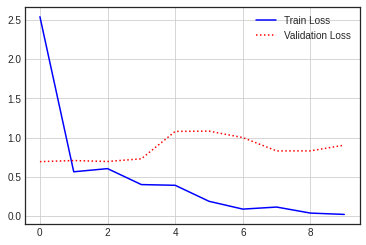

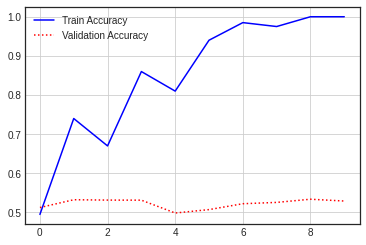

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r:', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

## 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련

### 테스트 데이터 토큰화